## Face Similarity Matching

In [11]:
# Import our libaries
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array,array_to_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

## Define our VGGFace Model

In [46]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D())
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))


model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

## Load our VGG Face Weights


In [47]:
from tensorflow.keras.models import model_from_json

#you can download the pretrained weights from the following link 
#https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing

model.load_weights('vgg_face_weights.h5')

In [16]:
# Understanding the function process_image:
from PIL import Image
img_data = np.random.random(size=(100, 100, 3))
imgs =array_to_img(img_data)
array =img_to_array(imgs)
print(array.shape)
imgs = np.expand_dims(imgs, axis=0)
print(imgs.shape)

(100, 100, 3)
(1, 100, 100, 3)


In [20]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)#Adding an extra dimension so as to match with Keras format
    img = preprocess_input(img)#To normalize the pixels from (0-255) to (0-1)
    return img

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

## Define our verifyFace function where we load to images of faces and compare them.

We set **epsilon** to be the threshold of whether our two faces are the same person. Setting a lower value makes it more strict with our face matching.

In [48]:
epsilon = 0.40

def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image('./training_faces/%s' % (img1)))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image('./training_faces/%s' % (img2)))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('./training_faces/%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('./training_faces/%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    print("Cosine similarity: ",cosine_similarity)
    
    if(cosine_similarity < epsilon):
        print("They are same person")
    else:
        print("They are not same person!")

## Let's a run a few tests

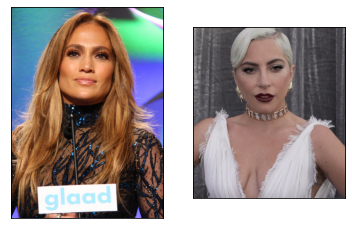

Cosine similarity:  0.5427860021591187
They are not same person!


In [34]:
#Jennifer Lopez with Lady Gaga
verifyFace("jlo.jpg", "ladygaga.jpg")

# Facial Recognition with One Shot Learning
## 1. Extract faces from pictures of people 
### Instrutions:
- Place photos of people (one face visible) in the folder called "./people"
- Faces are extracted using the haarcascade_frontalface_default detector model
- Extracted faces are placed in the folder called "./group_of_faces"
#### We are extracting the faces needed for our one-shot learning model, it will load 5 extracted faces

In [3]:
# The code below extracts faces from images and places them in the folder
import os
from os import listdir
from os.path import isfile, join
import cv2

# Create a function to setup the directories we'll be storing our images
def makedir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        return None
    else:
        pass

# Loading out HAARCascade Face Detector 
face_detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

# Directory of image of persons we'll be extracting faces from
mypath = "./people/"
image_file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# print(image_file_names)
print("Collected " + str(len(image_file_names)) + " images")
makedir("./group_of_faces/")

for image_name in image_file_names:
    person_image = cv2.imread(mypath+image_name)
    face_info = face_detector.detectMultiScale(person_image, 1.3, 5)
    for (x,y,w,h) in face_info:
        face = person_image[y:y+h, x:x+w]
        roi = cv2.resize(face, (128, 128), interpolation = cv2.INTER_CUBIC)
    
    path = "./group_of_faces/" + "face_" + image_name 
    cv2.imwrite(path, roi)
    cv2.imshow("face", roi)
    
    cv2.waitKey(0)
cv2.destroyAllWindows()

Collected 6 images


## Load our VGGFaceModel 
- This block of code defines the VGGFace model (which we use later) and loads the model

In [17]:
#author Sefik Ilkin Serengil
#you can find the documentation of this code from the following link: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

import numpy as np
import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from os import listdir

def preprocess_image(image_path):
    """Loads image from path and resizes it"""
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

#you can download pretrained weights from https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
from tensorflow.keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

model = vgg_face_descriptor

print(model.summary())
print("Model Loaded")

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_39_input (Inp [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_39 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 114, 114, 64)      0   

## Test model using your Webcam
This code looks up the faces you extracted in the "group_of_faces" folder and uses the similarity (Cosine Similarity) to detect which faces is most similar to the one being extracted with your webcam.

In [21]:
#points to your extracted faces
people_pictures = "./group_of_faces/"

all_people_faces = dict()

for file in listdir(people_pictures):
    person_face, extension = file.split(".")
    all_people_faces[person_face] = model.predict(preprocess_image('./group_of_faces/%s.jpg' % (person_face)))[0,:]

print("Face representations retrieved successfully")

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

#Open Webcam
cap = cv2.VideoCapture(0) 

while(True):
    ret, img = cap.read()
    faces = face_detector.detectMultiScale(img, 1.3, 5)

    for (x,y,w,h) in faces:
        if w > 80: #Adjust accordingly if your webcam resoluation is higher
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image
            detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
            detected_face = cv2.resize(detected_face, (224, 224)) #resize to 224x224

            img_pixels = image.img_to_array(detected_face)
            img_pixels = np.expand_dims(img_pixels, axis = 0)
            img_pixels /= 255

            captured_representation = model.predict(img_pixels)[0,:]

            found = 0
            for i in all_people_faces:
                person_name = i
                representation = all_people_faces[i]

                similarity = findCosineSimilarity(representation, captured_representation)
                if(similarity < 0.35):
                    cv2.putText(img, person_name[5:], (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    found = 1
                    break

            #connect face and text
            cv2.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),(255, 0, 0),1)
            cv2.line(img,(x+w,y-20),(x+w+10,y-20),(255, 0, 0),1)

            if(found == 0): #if found image is not in our people database
                cv2.putText(img, 'unknown', (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    cv2.imshow('img',img)

    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()

Face representations retrieved successfully


## Test on a video
### Since we're using the Friends TV Series characters, let's extract the faces from the images I placed in the "./friends" folder

In [22]:
from os import listdir
from os.path import isfile, join
import cv2

# Loading out HAARCascade Face Detector 
face_detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

# Directory of image of persons we'll be extracting faces frommy
mypath = "./friends/"
image_file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("Collected image names")
makedir("./friends_faces/")

for image_name in image_file_names:
    person_image = cv2.imread(mypath+image_name)
    face_info = face_detector.detectMultiScale(person_image, 1.3, 5)
    for (x,y,w,h) in face_info:
        face = person_image[y:y+h, x:x+w]
        roi = cv2.resize(face, (128, 128), interpolation = cv2.INTER_CUBIC)
    path = "./friends_faces/" + "face_" + image_name 
    cv2.imwrite(path, roi)
    cv2.imshow("face", roi)
    
    cv2.waitKey(0)
cv2.destroyAllWindows()

Collected image names


### Again, we load our faces from the "friends_faces" directory and we run our face classifier model our test video

In [23]:
#points to your extracted faces
people_pictures = "./friends_faces/"

all_people_faces = dict()

for file in listdir(people_pictures):
    person_face, extension = file.split(".")
    all_people_faces[person_face] = model.predict(preprocess_image('./friends_faces/%s.jpg' % (person_face)))[0,:]

print("Face representations retrieved successfully")

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

cap = cv2.VideoCapture('Friends.mp4')
frame_count = 0

while(True):
        ret, img = cap.read()
        img = cv2.resize(img, (320, 180)) # Re-size video to as smaller size to improve face detection speed
        img = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=[0,0,0])
        faces = face_detector.detectMultiScale(img, 1.3, 5)
        frame_count+=1
        for (x,y,w,h) in faces:
            if w > 13: 
                cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image

                detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
                detected_face = cv2.resize(detected_face, (224, 224)) #resize to 224x224

                img_pixels = image.img_to_array(detected_face)
                img_pixels = np.expand_dims(img_pixels, axis = 0)
                img_pixels /= 255

                captured_representation = model.predict(img_pixels)[0,:]

                found = 0
                for i in all_people_faces:
                    person_name = i
                    representation = all_people_faces[i]

                    similarity = findCosineSimilarity(representation, captured_representation)
                    if(similarity < 0.30):
                        cv2.putText(img, person_name[5:], (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        found = 1
                        break

                #connect face and text
                cv2.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),(255, 0, 0),1)
                cv2.line(img,(x+w,y-20),(x+w+10,y-20),(255, 0, 0),1)

                if(found == 0): #if found image is not in our people database
                    cv2.putText(img, 'unknown', (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        cv2.imshow('img',cv2.resize(img, (640, 360)))

        if cv2.waitKey(1) == 13: #13 is the Enter Key
            break
        else:
            pass

# Close openCV video capture imshow
cap.release()
cv2.destroyAllWindows()

Face representations retrieved successfully
